In [41]:
import pandas_datareader.data as web
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.stattools as ts 
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import requests


In [3]:
# Dynamic stock data fetched from wikipedia list of S&P 500 companies

def get_sp500_tickers():
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    html = requests.get(url).content
    df_list = pd.read_html(html)
    
    # The relevant table containing S&P 500 information is typically the first one
    sp500_table = df_list[0]
    
    # Extracting the columns of interest
    sp500_data = sp500_table[['Symbol', 'Security']]
    
    return sp500_data

# Call the function to get the S&P 500 data
sp500_data = get_sp500_tickers()
companies_dict = sp500_data.set_index('Symbol').to_dict()['Security']

# Display the data
print(len(companies_dict))
tickers = list(companies_dict.keys())



503


In [4]:
# Reading data from the given csv file

data = pd.read_csv('SP500_prices.csv')

In [5]:
# Data cleaning - removing columns with company names not in S&P 500

for c in data.columns[1:]:
    if c not in tickers:
        data = data.drop([c], axis=1)

# Data cleaning - datatype conversion and date filtering

data.date = pd.to_datetime(data.date)
data = data[data.date > "2018"][data.date < "2020"]
data.index = data["date"]
data.drop(columns=["date"],inplace=True)        

In [6]:
data.head()

,A,AAL,AAPL,ABBV,ABT,ACN,ADBE,ADI,ADM,ADP,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,65.305023,51.647560,41.075401,79.550964,54.646271,144.274887,177.699997,82.765312,35.165939,105.598396,...,154.734451,42.066658,66.545746,64.630898,64.491646,75.387535,116.359734,103.709999,44.894779,69.868118
2018-01-03,66.966637,51.014027,41.068260,80.795830,54.767101,144.940720,181.039993,83.792084,34.894012,106.745522,...,153.058075,41.785095,67.852715,64.409477,65.278023,75.322861,117.166344,105.769997,44.841648,70.189369
2018-01-04,66.464294,51.335659,41.259010,80.335068,54.674156,146.656967,183.220001,83.700409,35.481724,107.765190,...,153.886810,41.459538,67.946640,64.399857,65.713814,76.089676,116.997498,107.860001,45.027615,70.607986
2018-01-05,67.526939,51.316170,41.728756,81.733505,54.832184,147.866745,185.339996,84.039627,35.244881,107.701454,...,154.913391,41.169186,67.891838,65.304726,65.590652,76.533119,118.160545,109.540001,45.045311,71.415993
2018-01-08,67.671867,50.809345,41.573761,80.423965,54.674156,149.048401,185.039993,84.186310,35.165939,107.373703,...,152.850906,41.477135,68.197075,65.747551,65.827507,76.662468,118.385658,110.629997,44.823944,72.272667


In [7]:
returns_1_day = data.pct_change()
# returns_2_day = data.pct_change(2)
# returns_5_day = data.pct_change(5)
# returns_10_day = data.pct_change(10)
# returns_20_day = data.pct_change(20)
# returns_60_day = data.pct_change(60)
# returns_252_day = data.pct_change(252)



# Removing the first row of NaN values due to pct_change function

returns_1_day = returns_1_day.iloc[1:,:]





# list_of_returns = [returns_1_day,returns_2_day,returns_5_day,returns_10_day,returns_20_day,returns_60_day,returns_252_day]

In [8]:
# we can only work with stocks that have the full return series

# for returns in list_of_returns:
#     returns.dropna(axis=1,inplace=True)
#     returns = returns_1_day.iloc[1:,:]

# list_of_returns

In [9]:
# Checking for NaN values

# Check for missing values in returns_1_day
missing_values = returns_1_day.isnull().sum()

# Display columns with missing values
columns_with_missing_values = missing_values[missing_values > 0]
print("Columns with Missing Values:")
print(columns_with_missing_values)

# Display total number of missing values in each column
print("\nTotal Number of Missing Values in Each Column:")
print(missing_values)

# Print missing vlues in csv file

# missing_values.to_csv('missing.csv')



# As we can see, there are columns with missing values, we will drop them

returns_1_day.dropna(axis=1,inplace=True)


Columns with Missing Values:
CARR    502
CDAY     79
CEG     502
CTVA    350
DOW     304
FOX     299
FOXA    298
MRNA    235
OTIS    502
dtype: int64

Total Number of Missing Values in Each Column:
A       0
AAL     0
AAPL    0
ABBV    0
ABT     0
       ..
YUM     0
ZBH     0
ZBRA    0
ZION    0
ZTS     0
Length: 476, dtype: int64


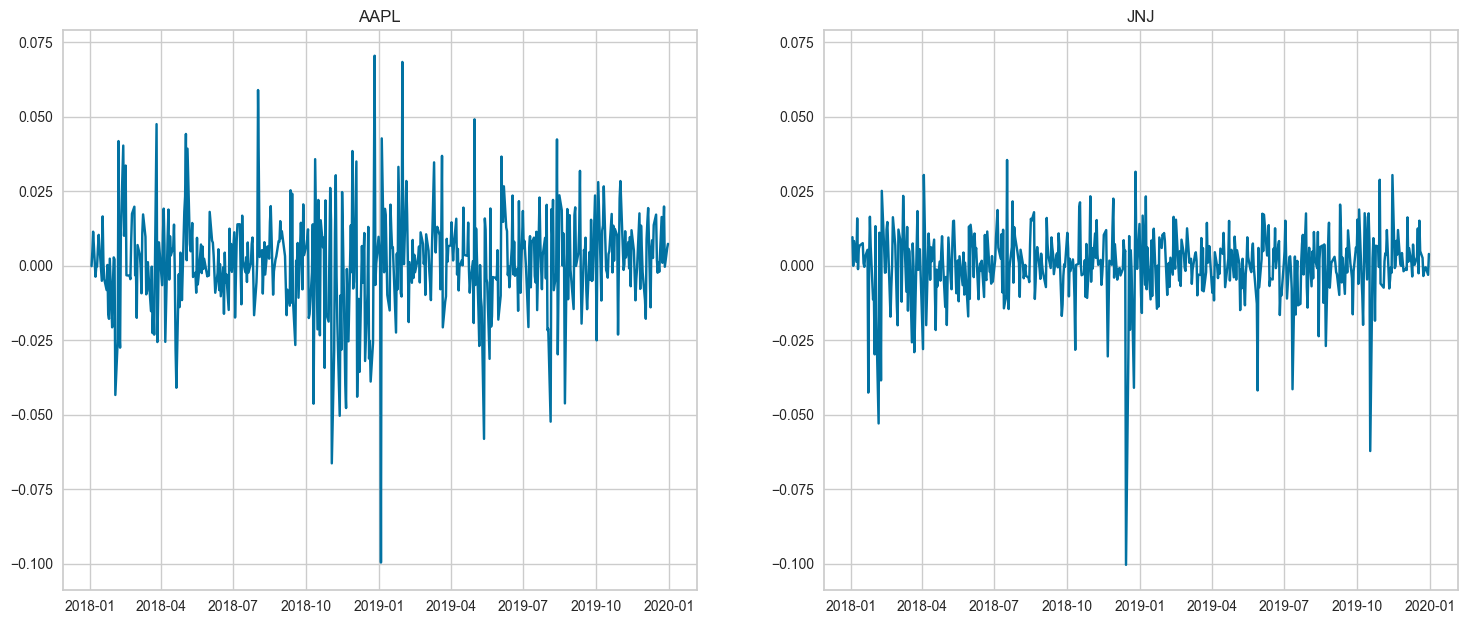

In [10]:
# Compare the movement of different stocks. 

plt.figure(figsize=(18,16))
ax1 = plt.subplot(221)
plt.plot(returns_1_day["AAPL"])
plt.title("AAPL")

plt.subplot(222, sharey=ax1)
plt.plot(returns_1_day["JNJ"])
plt.title("JNJ")
plt.show()

In [11]:
ret_T = returns_1_day.T

ret_T = pd.DataFrame(ret_T)
# ret_T.index = ret_T["Stock"]
ret_T.index.name = 'stock'
ret_T
# ret_T.rename(columns={"index":"Stock"},inplace=True)

date,2018-01-03,2018-01-04,2018-01-05,2018-01-08,2018-01-09,2018-01-10,2018-01-11,2018-01-12,2018-01-16,2018-01-17,...,2019-12-17,2019-12-18,2019-12-19,2019-12-20,2019-12-23,2019-12-24,2019-12-26,2019-12-27,2019-12-30,2019-12-31
stock,,,,,,,,,,,,,,,,,,,,,
A,0.025444,-0.007501,0.015988,0.002146,0.024554,-0.013655,0.000141,0.013136,-0.006971,0.011653,...,-0.005921,-0.006194,0.012945,0.008046,0.000822,0.000469,0.001758,-0.000351,-0.003989,0.004829
AAL,-0.012266,0.006305,-0.000380,-0.009877,-0.000959,0.032642,0.049089,0.036335,-0.008380,0.003105,...,0.012894,-0.009901,0.019643,0.017163,0.008953,-0.004096,0.016792,-0.041456,-0.004923,0.013428
AAPL,-0.000174,0.004645,0.011385,-0.003714,-0.000114,-0.000230,0.005680,0.010326,-0.005082,0.016516,...,0.001965,-0.002389,0.001001,-0.002071,0.016319,0.000951,0.019840,-0.000380,0.005935,0.007306
ABBV,0.015649,-0.005703,0.017408,-0.016022,0.007539,-0.005487,0.002930,0.010779,0.021427,0.018246,...,0.007268,-0.008326,-0.006269,0.005858,0.010751,-0.004432,-0.000223,-0.007013,-0.007623,0.000226
ABT,0.002211,-0.001697,0.002890,-0.002882,0.001700,-0.001527,0.006832,-0.001866,-0.006798,0.009411,...,0.007639,-0.001493,0.004832,-0.007899,0.007962,-0.000801,0.000000,0.001375,-0.006865,0.000691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YUM,-0.000858,0.010180,0.005828,0.001690,-0.002651,-0.002537,-0.000727,0.013699,-0.008252,0.001929,...,-0.012588,-0.008834,0.010938,0.007714,-0.007754,0.005210,0.014552,0.001081,-0.012365,0.000894
ZBH,0.006932,-0.001441,0.009941,0.001905,-0.016083,-0.013367,-0.001959,-0.001554,-0.003440,0.006657,...,-0.000933,-0.006539,-0.000537,0.010215,0.006120,-0.002447,-0.002191,-0.001929,-0.008399,0.006252
ZBRA,0.019863,0.019760,0.015576,0.009951,0.030643,0.006666,0.055672,0.016341,0.001868,0.003242,...,-0.007868,0.007852,-0.009004,-0.002528,0.016793,-0.009348,0.000354,0.006210,-0.007383,0.005234


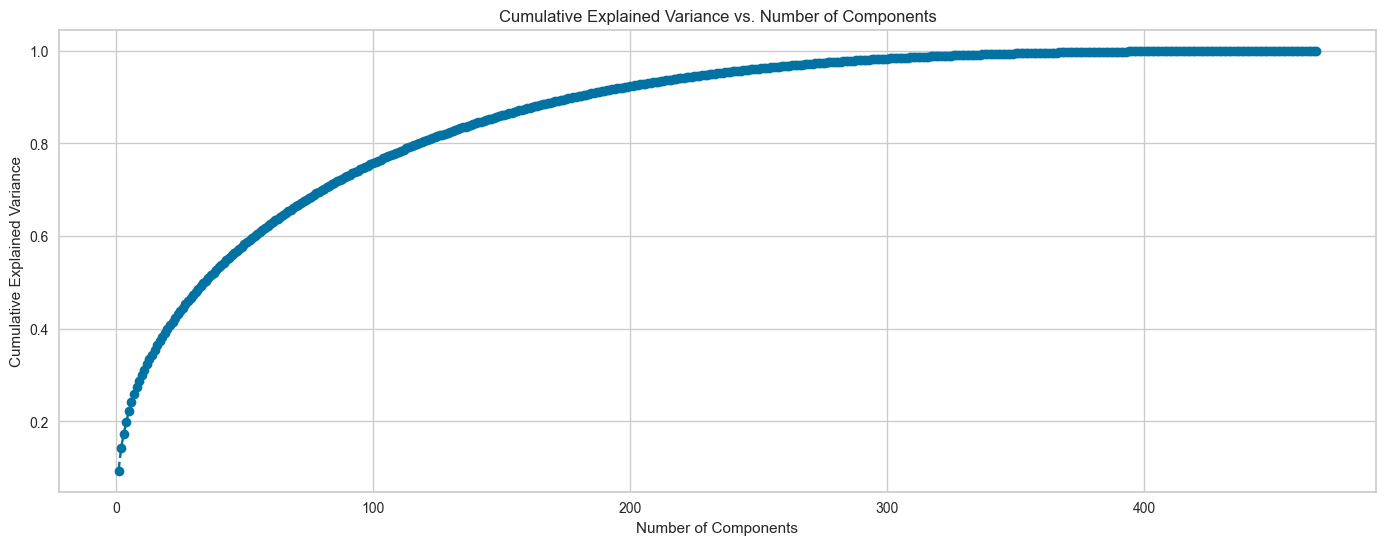

In [12]:
# Standardize the Data improve the robustness and performance of your models 
scaler = StandardScaler()
scaled_data = scaler.fit_transform(ret_T)

# PCA Dimensionality Reduction
pca = PCA()
pca.fit(scaled_data)

# Plot explained variance ratio to decide on the number of components
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(17, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()


In [13]:
# Check the number of components needed to explain 80% of the variance
for i in range(len(cumulative_explained_variance)):
    if cumulative_explained_variance[i] > 0.8:
        print(str(i) + " components needed to explain 80% of the variance")
        break

# Check the number of components needed to explain 90% of the variance
for i in range(len(cumulative_explained_variance)):
    if cumulative_explained_variance[i] > 0.9:
        print(str(i) + " components needed to explain 90% of the variance")
        break

117 components needed to explain 80% of the variance
178 components needed to explain 90% of the variance


In [14]:
# Choose the number of components based on the plot
n_components = 117
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(scaled_data)

# principal_components as a dataframe
principal_components = pd.DataFrame(principal_components)
principal_components


,0,1,2,3,4,5,6,7,8,9,...,107,108,109,110,111,112,113,114,115,116
0,2.352165,2.661666,-1.273558,-1.658860,-3.334617,-2.213262,-0.659270,5.030847,1.425124,2.782720,...,-0.681756,0.612717,1.149347,1.462562,0.159329,-1.428900,0.198273,-1.499848,-1.059869,-2.118678
1,9.685913,-1.369632,-7.756083,6.684084,7.071743,6.517872,5.419596,-3.405209,0.566303,1.673854,...,-0.016549,-1.729637,-0.852606,-0.349107,0.798168,-0.619323,-0.546373,1.648270,0.239696,1.297278
2,4.960104,5.734496,0.955692,-1.505828,2.864725,-0.929640,0.146926,-0.654462,-0.697894,-0.674877,...,0.713115,1.096792,0.117785,-0.051575,1.629970,-0.348698,0.991379,0.544496,-1.505288,-1.423201
3,-0.547323,0.504914,-0.150086,-1.948013,-2.309347,-4.842221,1.885639,2.054584,0.604620,1.308776,...,-0.277448,-1.749651,-0.684405,-0.145079,-2.521960,-0.649210,-2.490382,-2.154185,0.271728,-0.031092
4,-0.261493,4.169746,-0.761068,-0.978871,-3.193970,-2.692348,0.362224,3.932584,-0.043053,0.106655,...,1.366934,0.474394,-0.748211,-0.145911,-0.393938,0.192403,-0.679070,-0.403183,0.411746,1.006259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462,-5.546530,1.661695,-0.712075,0.840117,-1.212811,0.565429,-1.750828,-0.692053,0.034593,-1.743712,...,-1.025091,0.540778,1.347604,1.170746,0.166011,-0.206344,-1.334057,0.666646,-0.791146,-0.159341
463,-1.871836,2.192568,0.586082,-0.902054,-1.055977,-3.470796,1.888789,2.161413,0.370638,-0.594555,...,1.528576,-0.421561,0.033126,0.261674,0.617586,-0.228059,1.303389,-0.524224,-1.473670,-0.827880
464,8.141745,6.228313,2.189951,-1.644857,-0.612663,5.427864,2.391901,0.697229,-1.308005,2.537716,...,-0.618345,0.953842,-0.417763,0.601392,-1.061463,-0.883960,-1.070619,0.050414,-0.827258,-1.001746
465,5.222995,-7.508491,-3.987962,7.064611,-1.867738,-4.932540,-2.198491,-5.356795,1.143155,0.519521,...,0.573711,-1.272289,0.907575,-0.204586,-0.498104,0.254692,0.478067,0.629807,-0.503490,-0.457070


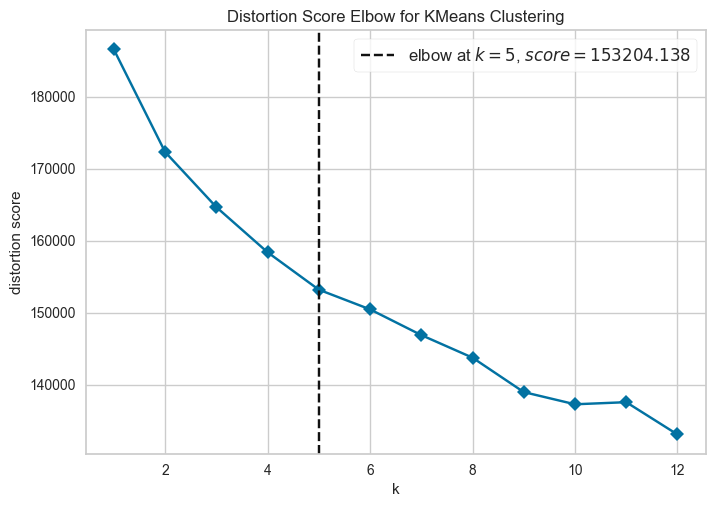

In [15]:
# Create k-Means model and find optimal number of clusters with the elbow method

model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(1,13), timings=False
)

visualizer.fit(principal_components)        
visualizer.show()
n_clusters = visualizer.elbow_value_

kmeans = KMeans(n_clusters=n_clusters)
cluster_assignments = kmeans.fit_predict(principal_components)

In [16]:
# Add the cluster assignments to a copy of the returns dataframe

returns_clustered = ret_T.copy()
returns_clustered['Cluster'] = cluster_assignments

# Explore Clusters
# Explore the clusters to identify potential pairs

for cluster_id in range(n_clusters):
    cluster_stocks = returns_clustered[returns_clustered['Cluster'] == cluster_id].drop(columns=['Cluster'])
    mean_returns = cluster_stocks.mean(axis=1)
    print(f'\nCluster {cluster_id + 1} Mean Returns:')
    print(f'Total Mean Return: {mean_returns.mean()}')
    print(f'Size: {mean_returns.count()} Stocks')
    print(mean_returns.sort_values(ascending=False).head())




# Additional Steps:
# - Choose pairs from the identified clusters for pairs trading
# - Develop and back-test the pairs trading strategy
# - Analyze and evaluate the performance of the strategy


Cluster 1 Mean Returns:
Total Mean Return: 0.00012718454254899222
Size: 129 Stocks
stock
GNRC    0.001633
HES     0.001018
GWW     0.000988
TT      0.000974
OKE     0.000948
dtype: float64

Cluster 2 Mean Returns:
Total Mean Return: 0.003939526755781588
Size: 2 Stocks
stock
ENPH    0.005792
ETSY    0.002087
dtype: float64

Cluster 3 Mean Returns:
Total Mean Return: 0.0006126953033478739
Size: 190 Stocks
stock
CMG     0.002347
TDG     0.001770
CPRT    0.001599
TGT     0.001585
RMD     0.001404
dtype: float64

Cluster 4 Mean Returns:
Total Mean Return: 0.0005499753582464469
Size: 80 Stocks
stock
KDP     0.001475
AES     0.001457
MKTX    0.001419
MKC     0.001178
FE      0.001126
dtype: float64

Cluster 5 Mean Returns:
Total Mean Return: 0.001153872027236859
Size: 66 Stocks
stock
AMD     0.003521
DXCM    0.003121
PAYC    0.002684
MTCH    0.002465
SEDG    0.002410
dtype: float64


In [17]:
n_clusters 

5

In [18]:
# Create and fit the model with the optimal number of clusters from above
model = KMeans(n_clusters = n_clusters)
model.fit(ret_T)

labels = model.predict(ret_T)

# create a DataFrame aligning labels & companies
clusters = pd.DataFrame({'cluster': labels, 'ticker': returns_1_day.columns})

for i in clusters.index:
    clusters.loc[i,"company"] = companies_dict[clusters.loc[i,"ticker"]]

# display df sorted by cluster labels. Would you say that the clustering makes sense?
clusters.sort_values('cluster').reset_index(drop=True)
# clusters.to_csv('clusters.csv')

,cluster,ticker,company
0,0,SJM,J.M. Smucker Company (The)
1,0,PLD,Prologis
2,0,CHD,Church & Dwight
3,0,PM,Philip Morris International
4,0,PNW,Pinnacle West
...,...,...,...
462,4,ON,ON Semiconductor
463,4,COF,Capital One
464,4,PCAR,Paccar
465,4,NDSN,Nordson Corporation


In [19]:
# Explore the clusters to identify potential pairs

for cluster_id in range(n_clusters):
    cluster_stocks = ret_T[ret_T.index.isin(clusters[clusters['cluster']==cluster_id]['ticker'])]
    mean_returns = cluster_stocks.mean(axis=1)
    print(f'\nCluster {cluster_id + 1} Mean Returns:')
    print(f'Total Mean Return: {mean_returns.mean()}')
    print(f'Size: {mean_returns.count()} Stocks')
    print(mean_returns.sort_values(ascending=False).head())


Cluster 1 Mean Returns:
Total Mean Return: 0.0005513991640076229
Size: 78 Stocks
stock
AES     0.001457
MKTX    0.001419
MKC     0.001178
FE      0.001126
AMT     0.001125
dtype: float64

Cluster 2 Mean Returns:
Total Mean Return: 0.0006184761877159735
Size: 188 Stocks
stock
CMG     0.002347
TDG     0.001770
CDW     0.001608
CPRT    0.001599
TGT     0.001585
dtype: float64

Cluster 3 Mean Returns:
Total Mean Return: -0.00025345737570905687
Size: 12 Stocks
stock
HES    0.001018
COP    0.000566
PXD   -0.000012
MRO   -0.000102
BKR   -0.000128
dtype: float64

Cluster 4 Mean Returns:
Total Mean Return: 0.0014162312987288305
Size: 48 Stocks
stock
ENPH    0.005792
AMD     0.003521
DXCM    0.003121
PAYC    0.002684
MTCH    0.002465
dtype: float64

Cluster 5 Mean Returns:
Total Mean Return: 0.0002597962956039351
Size: 141 Stocks
stock
GNRC    0.001633
KLAC    0.001363
QRVO    0.001334
LRCX    0.001246
TER     0.001187
dtype: float64


In [20]:
clusters.groupby("cluster").count()

,ticker,company
cluster,,
0,78,78
1,188,188
2,12,12
3,48,48
4,141,141
